In [1]:
import actionet
import actionet.preprocessing
import scipy
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
from anndata import AnnData

In [2]:
import matplotlib.pyplot as plt

In [ ]:
# X = scipy.io.mmread("data/counts.mtx")
# obs_df = pd.read_csv("data/sample_data.tsv", sep="\t", header=0)
# var_df = pd.read_csv("data/feature_data.tsv", sep="\t", header=0)

In [ ]:
# adata = anndata.AnnData(
#     X=scipy.sparse.csr_matrix(X).T,
#     var=var_df,
#     obs=obs_df
# )
# adata.write_h5ad("../data/test_adata.h5ad")

In [3]:
adata = anndata.read_h5ad("../data/test_adata.h5ad")

In [4]:
adata = actionet.preprocessing.filter_anndata(adata, min_cells_per_feat=0.01, inplace=False)

In [5]:
adata.layers['logcounts'] = sc.pp.normalize_total(adata, target_sum=1e4, inplace=False)['X']
sc.pp.log1p(adata, layer='logcounts', base=2, copy=False)

In [6]:
actionet.reduce_kernel(adata, n_components=30, layer='logcounts', key_added='action', inplace=True)

Computing reduced ACTION kernel:
Performing SVD using IRLB (sparse) -- A: 14409 x 6790


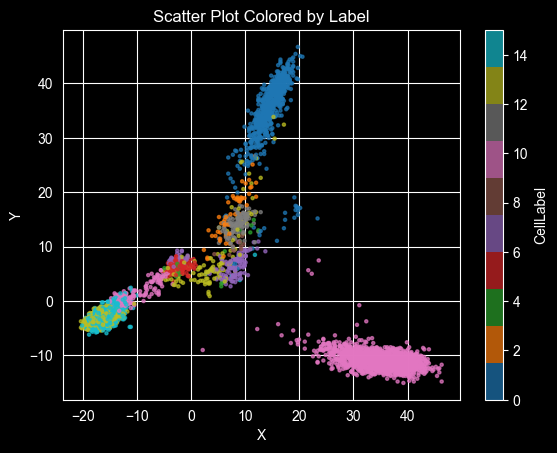

In [7]:
labels = adata.obs['CellLabel'].astype('category')
colors = labels.cat.codes  # Convert categories to integers

plt.scatter(
    x=adata.obsm['action'][:, 0],
    y=adata.obsm['action'][:, 1],
    c=colors,
    cmap='tab10',  # or another categorical colormap
    alpha=0.7,
    s = 5
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot Colored by Label')
plt.colorbar(label='CellLabel')
plt.show()

In [8]:
actionet.run_action(adata, k_min=2, k_max=30, reduction_key='action', n_threads=0, inplace=True)

Running ACTION (14 threads):
	Iterating from k = 2 ... 30: 29/29 finished
Joining trace of C & H matrices (depth = 30) ... done (464 archetypes)
Pruning archetypes:
	Non-specific archetypes: 4
	Unreproducible archetypes: 64
	Trivial archetypes: 1
Merging 395 archetypes:
Archetypes in merged set: 24


In [ ]:
adata.obsm['H_stacked']

In [ ]:
actionet.build_network(
    adata,
    obsm_key="H_stacked",
    algorithm="k*nn",
    distance_metric="jsd",
    mutual_edges_only=True,
    key_added="actionet",
    n_threads=0, inplace=True
)

Building adaptive network (density = 1.00)
	Building index ... done
	Identifying nearest neighbors ... done
	Constructing adaptive-nearest neighbor graph ... done
	Finalizing network ... done


In [ ]:
adata.obsp['actionet'].sum(axis=0)

In [ ]:
actionet.compute_network_diffusion(
    adata,
    scores=adata.obsm['H_merged'],
    norm_method='pagerank',
    network_key="actionet",
    n_threads=0,
    alpha=0.85,
    key_added="archetype_footprint",
    inplace = True
)

In [ ]:
adata.obsm['archetype_footprint']
# adata.obsm['H_merged']

In [ ]:
actionet.layout_network(
    adata,
    network_key='actionet',
    initial_coords=adata.obsm['archetype_footprint'],
    method='umap',
    n_components=2,
    spread=1.0,
    min_dist=1.0,
    n_epochs = 100,
    seed=0,
    key_added='umap', inplace=True
)

In [ ]:
labels = adata.obs['CellLabel'].astype('category')
colors = labels.cat.codes  # Convert categories to integers

plt.scatter(
    x=adata.obsm['umap'][:, 0],
    y=adata.obsm['umap'][:, 1],
    c=colors,
    cmap='tab10',  # or another categorical colormap
    alpha=0.7,
    s = 5
)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot Colored by Label')
plt.colorbar(label='CellLabel')
plt.show()

In [ ]:
adata